## Importing packages

In [90]:
import torch
import numpy as np 
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random
import cv2
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

## Reading the images

In [91]:
#loading and preprocessing tumor images
#--resizing to 128x128 pixels to ensure consistency among all images
#--color channels of the image are split into blue (b), green (g), and red (r)
#--the channels are then merged back in the original order (since OpenCV loads images in BGR format)
tumor = []
healthy = []
for f in glob.glob('./data/brain_tumor_dataset/yes/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([b, g, r])
    tumor.append(img)

for f in glob.glob('./data/brain_tumor_dataset/no/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([b, g, r])
    healthy.append(img)

In [92]:
#list to array
healthy = np.array(healthy) 
tumor = np.array(tumor)
#concatenate datasets
All = np.concatenate((healthy, tumor))

In [93]:
healthy.shape

(85, 128, 128, 3)

In [94]:
tumor.shape

(86, 128, 128, 3)

In [95]:
np.random.choice(10, 5, replace=False)

array([0, 2, 4, 8, 3])

## Visualizing Brain MRI images

In [96]:
#visualizing random samples of MRI images from two categories: healthy and tumor
#for each image in the random sample of healthy images, a subplot is created in a single row (plt.subplot(1, num, i+1)). 
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

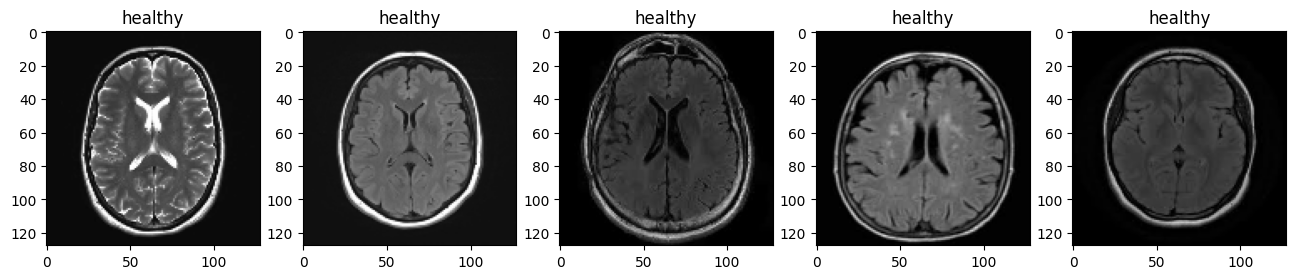

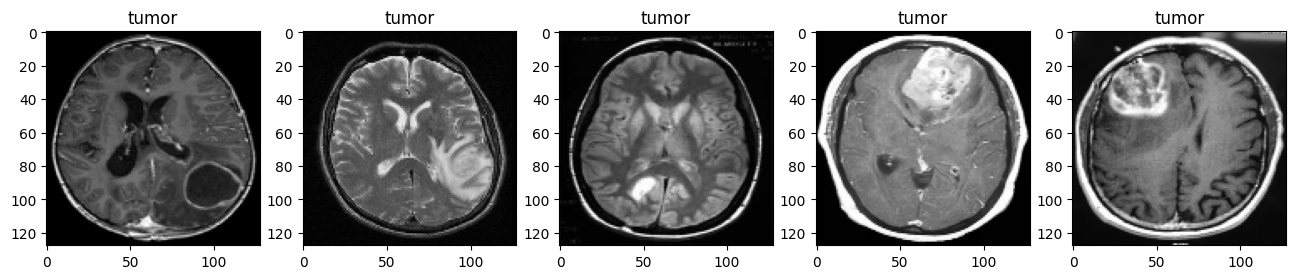

In [97]:
plot_random(healthy, tumor)

## Create torch dataset class

In [98]:
class Dataset(object):
    """An abstract class representing a Dataset.

    __getitem__(self, index) Method:
        This is a special method in Python that allows instances of the class to use the indexing syntax (e.g., dataset[0] to get the first element). In the context of a dataset, this method is supposed to return the index-th sample from the dataset.
        The base class raises a NotImplementedError, indicating that any subclass deriving from Dataset must provide its own implementation of how to access data by index. This is essential because the way data is stored and retrieved can vary widely between different datasets.

    __len__(self) Method:
        Another special method that allows Python to use the len() function on instances of the class (e.g., len(dataset) to get the number of items in the dataset).
        Similar to __getitem__, it raises a NotImplementedError, requiring subclasses to implement their own method for reporting the size of the dataset. This is crucial for knowing the dataset's bounds and iterating over it.

    __add__(self, other) Method:
        This method enables the use of the + operator with instances of the class, allowing two datasets to be concatenated simply by using dataset1 + dataset2.
        The method returns an instance of a ConcatDataset, presumably another class defined elsewhere, initialized with a list containing self and other. This implies that ConcatDataset is designed to handle multiple datasets as one unified dataset.
        By implementing this method, the class provides a convenient way to merge datasets, which can be very useful in situations where data from multiple sources needs to be combined into a single dataset for training or evaluation in machine learning tasks.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [99]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    # Returns the total number of images in the dataset by accessing the shape of the self.images array
    def __len__(self):
        return self.images.shape[0]
    
    # Returns a dictionary with two keys: 'image' for the image at the specified index and 'label' for its corresponding label
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    # Divides each pixel value by 255 to scale the image pixel values to the range [0, 1]
    def normalize(self):
        self.images = self.images/255.0

In [100]:
mri_dataset = MRI()
mri_dataset.normalize()

## Creating a dataloader

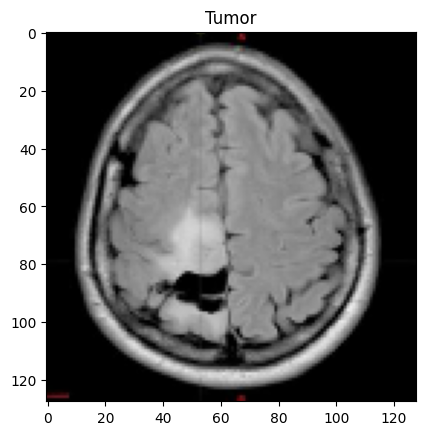

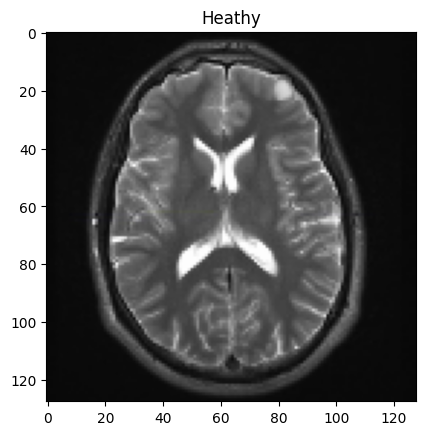

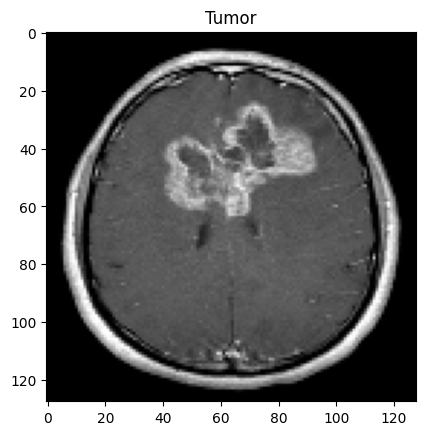

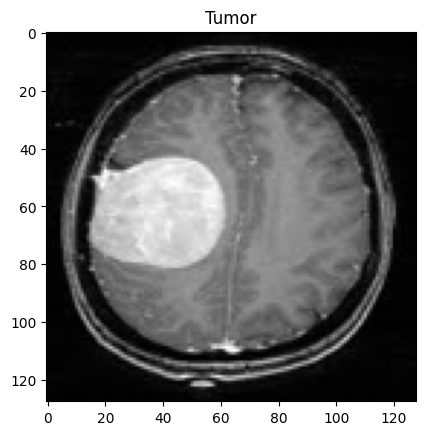

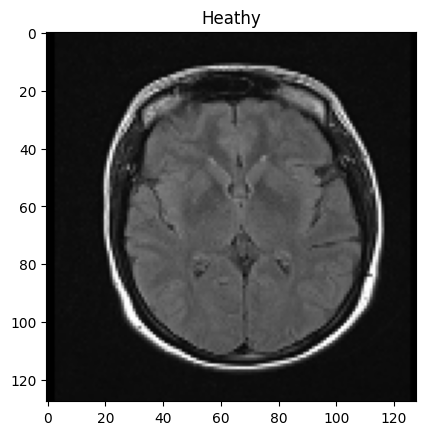

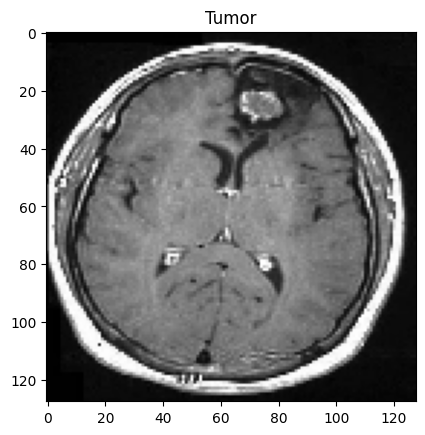

In [101]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# CNN Architecture Design Considerations

The values chosen for the inputs in your CNN architecture, such as the number of channels, kernel sizes, strides, and in/out features for linear layers, are critical design decisions that significantly impact the network’s performance. Understanding when and why you might change these values can help optimize your model for specific tasks.

## Key Components of CNN Architecture

### Convolutional Layers

- **in_channels=3:** This is standard for RGB images, which have three color channels. For grayscale images, you would use in_channels=1.
- **out_channels:** Determines the number of filters. Increasing out_channels allows the model to learn more features from the input images.
- **kernel_size=5:** Affects the receptive field of each convolutional operation.
- **Strides and Pooling:** The stride in `AvgPool2d(kernel_size=2, stride=5)` is unusually large.

### Fully Connected Layers

- **in_features=256 and subsequent layer sizes:** The design of fully connected layers depends on the flattened size of the output from the last convolutional/pooling layer.

## Adjusting Values

- **Task Complexity:** Adjustments based on the complexity of the classification tasks or image resolutions.
- **Input Image Size:** Adjustments required if the size of your input images changes.
- **Performance Considerations:** Increasing the network’s capacity or adding regularization.
- **Computational Efficiency:** Balancing model size and computational resources.

## Downsampling

Downsampling refers to the process of reducing the resolution or dimensionality of data.

### Methods of Downsampling

- **Pooling Layers:** Includes Max Pooling and Average Pooling.
- **Strided Convolutions:** Using convolutional layers with a stride greater than one.
- **Dilated Convolutions:** Primarily used to increase the receptive field.
- **Resizing:** Directly resizing the image to lower dimensions.

## Activation Function: nn.Tanh()

- **When to Use:** Zero-Centered Data, Intermediate Layers. However, its usage has been somewhat superseded by other activation functions like ReLU in many scenarios.


In [102]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

# Some Basics of Training and Evaluation in PyTorch

Understanding the basics of training and evaluation is crucial in PyTorch. This guide covers the core concepts and compares essential data structures like numpy arrays and tensors.

## Model Modes

### `model.eval()`

- **Purpose:** Primarily used for inference. It is not involved with gradient computation.
- **Behavior Changes:** Disables dropout and makes batch norm use the entire population statistics, which is necessary for accurate inference.

### `model.train()`

- **Purpose:** Prepares the model for training.
- **Behavior:** Activates dropout and batch normalization. Gradients are computed during this mode.

## Understanding Data Structures

### Numpy Array vs Tensor

The difference between a NumPy array and a tensor is that the tensors are backed by the accelerator memory like GPU and they are immutable, unlike NumPy arrays. 
You can never update a tensor but create a new one. If you are into machine learning or going to be into it, A Tensor is a suitable choice if you are going to
use GPU. A tensor can reside in accelerator’s memory.

- The numpy arrays are the core functionality of the numpy package designed to support faster mathematical operations. Unlike python’s inbuilt list data 
    structure, they can only hold elements of a single data type. Library like pandas which is used for data preprocessing is built around the numpy array 
    **Pytorch tensors are similar to numpy arrays, but can also be operated on CUDA-capable Nvidia GPU.**
- Numpy arrays are mainly used in typical machine learning algorithms (such as k-means or Decision Tree in scikit-learn) whereas pytorch tensors are mainly used 
    in deep learning which requires heavy matrix computation.
- Unlike numpy arrays, while creating pytorch tensor, it also accepts two other arguments called the device_type (whether the computation happens on CPU or GPU) 
    and the requires_grad (which is used to compute the derivatives).

## Tensors in PyTorch

### `torch.tensor` vs. `torch.cuda.tensor`

- **Key Difference:** `torch.Tensor` is stored in CPU memory, while `torch.cuda.Tensor` resides in GPU memory. Operations on a CPU tensor utilize the CPU, whereas those on a GPU tensor leverage the GPU's power.

Remember, the choice between numpy arrays and tensors, as well as the decision to use CPU or GPU memory, depends on your specific machine learning or deep learning task requirements.


In [103]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.6899, 0.3298, 0.1209, 0.1933, 0.8325, 0.2297, 0.4926, 0.5611, 0.0236,
        0.6232], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.6899, 0.3298, 0.1209, 0.1933, 0.8325, 0.2297, 0.4926, 0.5611, 0.0236,
        0.6232], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([4.7593e-01, 1.0879e-01, 1.4627e-02, 3.7372e-02, 6.9309e-01, 5.2777e-02,
        2.4268e-01, 3.1486e-01, 5.5588e-04, 3.8832e-01], device='cuda:0')


As the underlying hardware interface is completely different, CPU Tensors are just compatible with CPU Tensor and vice versa GPU Tensors are just compatible to 
GPU Tensors.


### In which scenario is torch.cuda.Tensor() necessary?
When you want to use GPU acceleration (which is much faster in most cases) for your program, you need to use torch.cuda.Tensor, but you have to make sure that 
ALL tensors you are using are CUDA Tensors, mixing is not possible here.


### tensor.cpu().detach().numpy(): Convert Pytorch tensor to Numpy array
As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must 
explicitly remove the computational graph of the tensor using the detach() command. .cpu() returns a copy of this object in CPU memory.

# Evaluate new NN

In [104]:
mri_dataset = MRI()
mri_dataset.normalize() # scaling the input features (in this case, MRI images) so that they have a mean of 0 and a standard deviation of 1, 
                        # or scaling them to a range [0, 1] or [-1, 1]
device = torch.device('cuda:0') # tells PyTorch to use a CUDA-enabled GPU
model = CNN().to(device)

In [105]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False) # The batch size of 32 is a common default that tends to work well in practice for a wide range of tasks
                                                                   # might be chosen because the code snippet is for evaluating the model or for a task where the order of data matters

In [106]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [107]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [108]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [109]:
accuracy_score(y_true, threshold(outputs))

0.49707602339181284

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

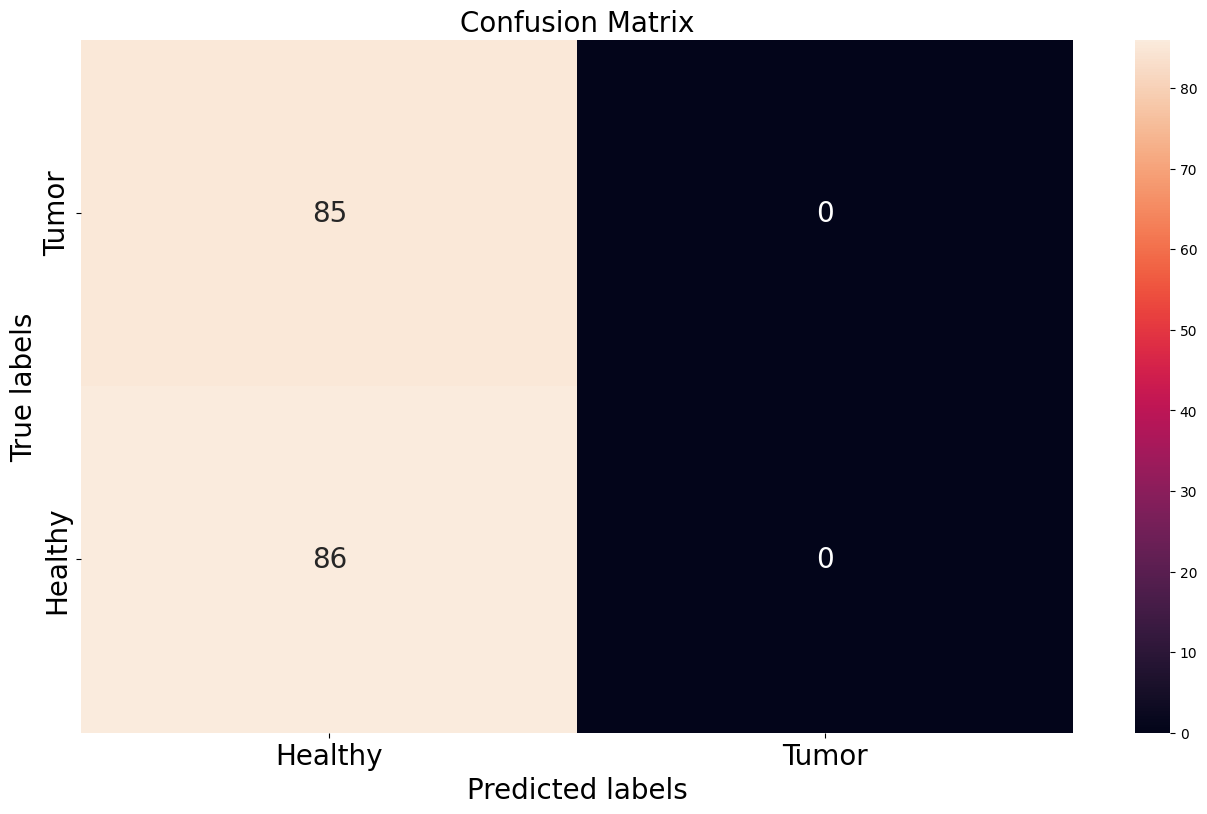

In [110]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

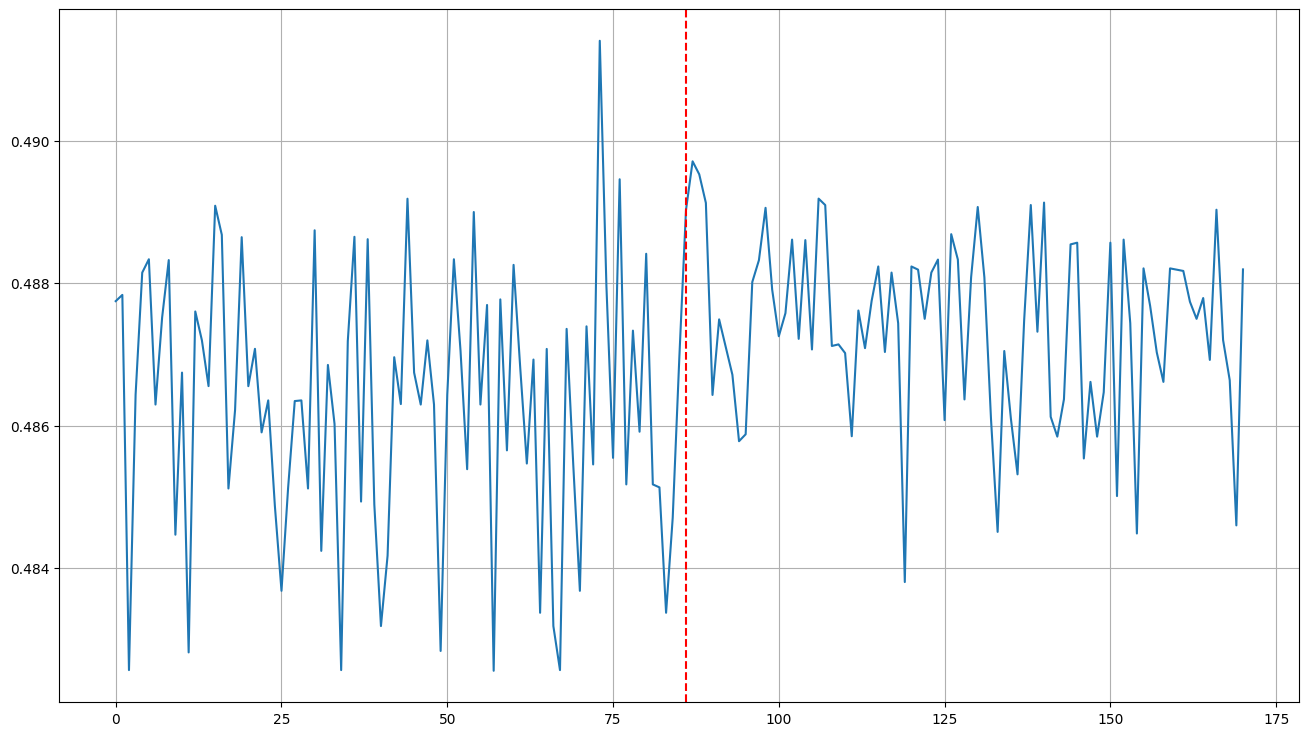

In [111]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Train the model

In [112]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta) #  implements the Adam algorithm
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train

<bound method Module.train of CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)>

In [113]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.684074
Train Epoch: 20	Loss: 0.666791
Train Epoch: 30	Loss: 0.643486
Train Epoch: 40	Loss: 0.592676
Train Epoch: 50	Loss: 0.560334
Train Epoch: 60	Loss: 0.518891
Train Epoch: 70	Loss: 0.537192
Train Epoch: 80	Loss: 0.496871
Train Epoch: 90	Loss: 0.464450
Train Epoch: 100	Loss: 0.433108
Train Epoch: 110	Loss: 0.408622
Train Epoch: 120	Loss: 0.361560
Train Epoch: 130	Loss: 0.352850
Train Epoch: 140	Loss: 0.342126
Train Epoch: 150	Loss: 0.333493
Train Epoch: 160	Loss: 0.311834
Train Epoch: 170	Loss: 0.302154
Train Epoch: 180	Loss: 0.244392
Train Epoch: 190	Loss: 0.237738
Train Epoch: 200	Loss: 0.209771
Train Epoch: 210	Loss: 0.245824
Train Epoch: 220	Loss: 0.165771
Train Epoch: 230	Loss: 0.165761
Train Epoch: 240	Loss: 0.145755
Train Epoch: 250	Loss: 0.119048
Train Epoch: 260	Loss: 0.101756
Train Epoch: 270	Loss: 0.090982
Train Epoch: 280	Loss: 0.071429
Train Epoch: 290	Loss: 0.062537
Train Epoch: 300	Loss: 0.048269
Train Epoch: 310	Loss: 0.039101
Train Epoch: 320	

## Evaluate the model

In [114]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad(): # context manager is used to disable gradient calculation, reducing memory consumption and speeding up computations since gradients aren't needed for model evaluation.
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [115]:
accuracy_score(y_true, threshold(outputs))


1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

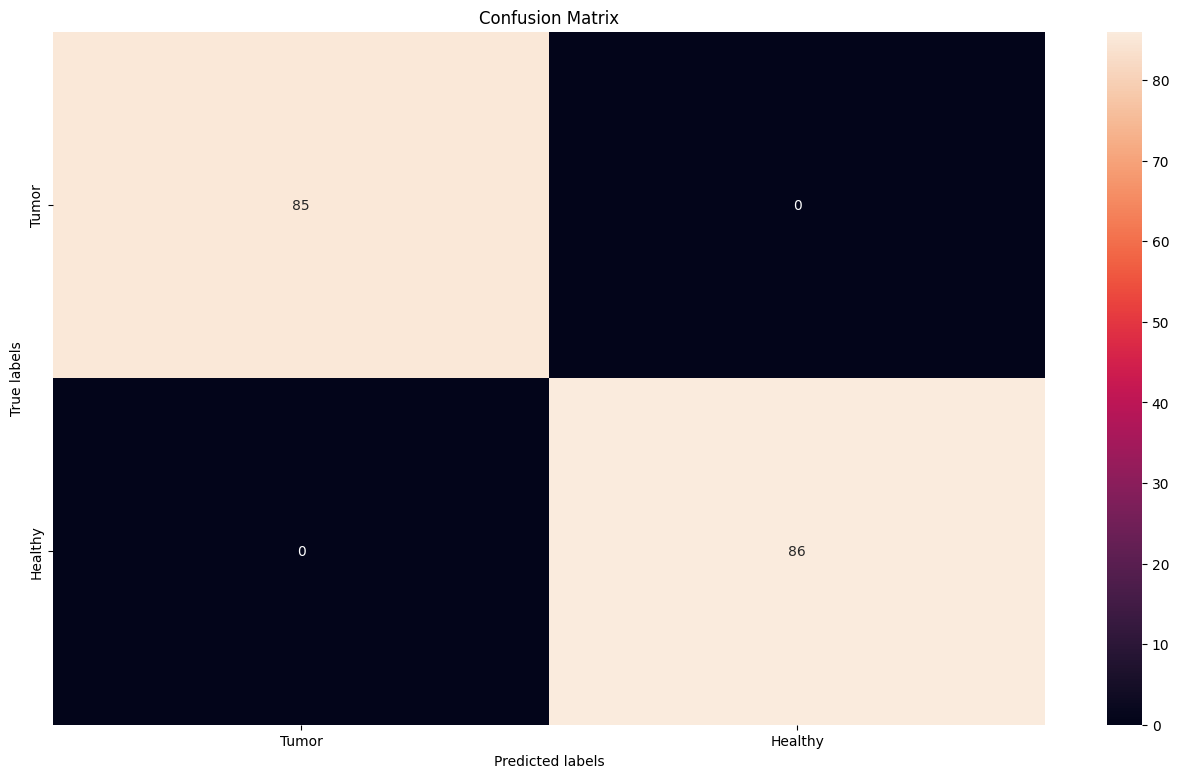

In [116]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

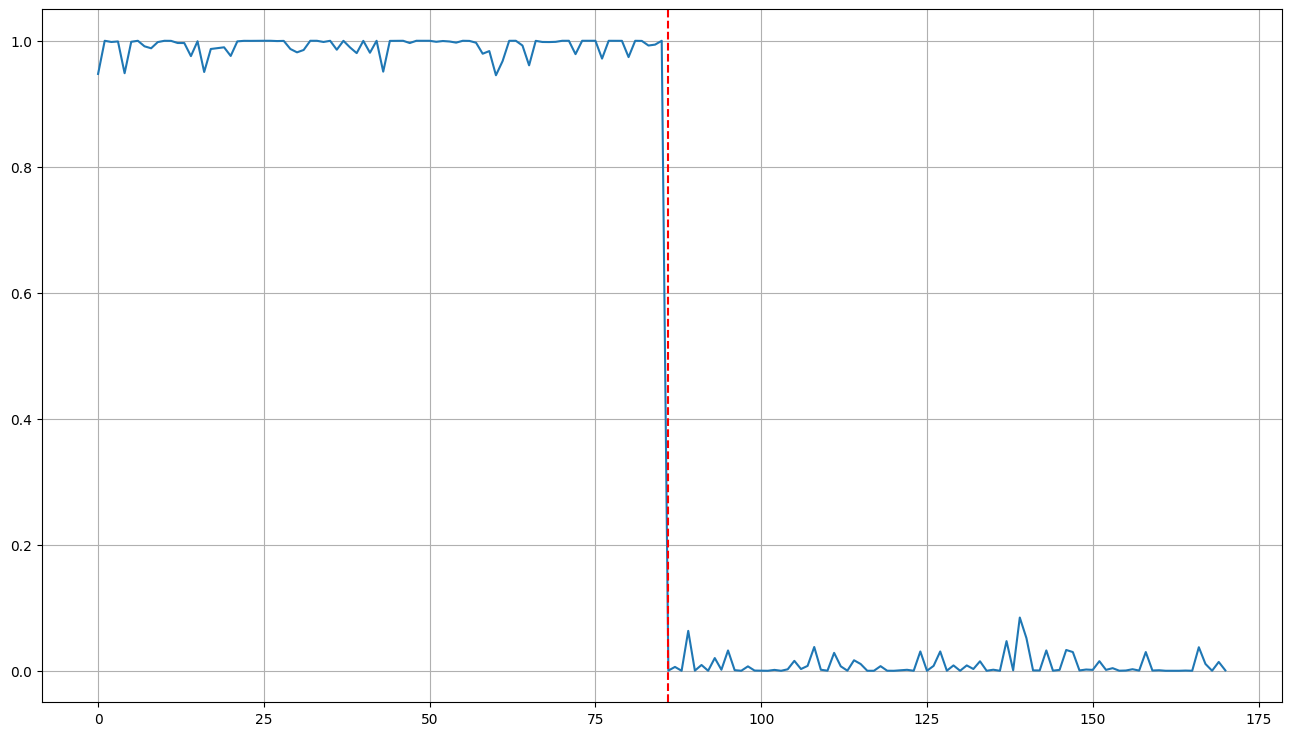

In [117]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [118]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [119]:
no_of_layers = 0
conv_layers = []

In [120]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [121]:
conv_layers

[]

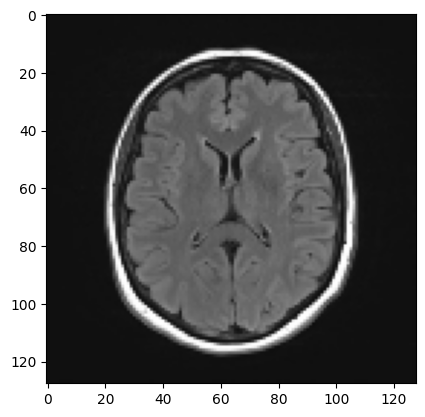

In [122]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [123]:
img = torch.from_numpy(img).to(device)

In [124]:
img.shape

torch.Size([3, 128, 128])

In [125]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])